### *Emre Can Şahin - 2210356146*

### HDR IMAGES LINK : https://drive.google.com/drive/folders/1C0y8k0G6U2dZuPYdsVhzKauRsVhMPm9w?usp=sharing

### 1. HDR Imaging (60 points)

You are provided with both RAW (with .NEF extensions) and rendered (with .JPG extensions) images in the data folder, both of which are to be used to create HDR images.

#### 1.1. Develop RAW images (5 points)

To convert RAW .NEF images into linear 16-bit .TIFF images, use dcraw and specify the camera's profile for white balancing, high-quality interpolation for demosaicing, and sRGB as the output color space. The correct set of flags for this conversion can be found in dcraw's documentation. Report them in the below cell.

#####  ***dcraw -w -q 3 -T -4 -o 1 _MDF0023.NEF***
##### -w	Use the camera's white balance settings embedded in the RAW file.
##### -q 3	Use high-quality demosaicing.##### -T	Output the result as a TIFF image.
##### -4	Produce a 16-bit linear TIFF image.
##### -o 1	Use the sRGB color space for output.


In [18]:
raw_files = glob.glob(os.path.join("data", "Lab Booth",  "*.nef"))
for file in raw_files:
    command = f"dcraw -w -q 3 -T -4 -o 1 \"{file}\""
    print("In processing:", file)
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

In processing: data\Lab Booth\_MDF0019.NEF
In processing: data\Lab Booth\_MDF0020.NEF
In processing: data\Lab Booth\_MDF0021.NEF
In processing: data\Lab Booth\_MDF0022.NEF
In processing: data\Lab Booth\_MDF0023.NEF
In processing: data\Lab Booth\_MDF0024.NEF
In processing: data\Lab Booth\_MDF0025.NEF
In processing: data\Lab Booth\_MDF0026.NEF
In processing: data\Lab Booth\_MDF0027.NEF


#### 1. 2. Weighting Schemes

You are expected to implement 4 different weighting schemes, namely, uniform, tent, Gaussian, and photon. (All hold the assumption that the intensity values z $\in$ [0,1]).

\\begin{eqnarray}
w_{\text{uniform}} & = & \left\{
        \begin{array}{ll}
            1, & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right.\\\nonumber
w_{\text{tent}} & = & \left\{
        \begin{array}{ll}
            \text{min}(z,1-z), & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right. \\\nonumber
w_{\text{Gaussian}} & = & \left\{
        \begin{array}{ll}
            \text{exp}\left(-4\frac{(z-0.5)^2}{0.5^2}\right), & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right. \\\nonumber
w_{\text{photon}} & = & \left\{
        \begin{array}{ll}
            t^k, & \;\, \text{if}\;\, Z_{\text{min}}\leq z \leq Z_{\text{max}}, \\
            0, & \;\, \text{otherwise}
        \end{array},
    \right.
\end{eqnarray} 

Though the recommended values for $Z_{\text{max}}$ and $Z_{\text{min}}$ are 0.05 and 0.95 respectively, you can experiment with different clipping values. 


 

In [1]:
import glob
import os
import subprocess
import cv2
import numpy as np
from typing import Callable

In [2]:
## Implement (possibly) functions or a class for these weighting schemes

z_min = 0.05
z_max = 0.95
def w_uniform(z, *_):
    return np.where((z >= z_min) & (z <= z_max), 1, 0)

def w_tent(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.minimum(z, 1 - z), 0)

def w_gaussian(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.exp(-4 * (z - 0.5)**2 / (0.5**2)), 0)

def w_photon(z, t):
    return np.where((z >= z_min) & (z <= z_max), t, 0)

w_functions = {
    'uniform': w_uniform,
    'tent': w_tent,
    'gaussian': w_gaussian,
    'photon': w_photon
}

#### 1.3. Linearize rendered images (25 points)

Rendered images, being non-linear, need to be linearized before merging into HDR images. For this, we'll use the method by Debevec and Malik [1]. Please refer to the homework text and the paper for any implementation detail.

$I^k_{ij}: $ intensity of pixel (i, j) of the $k^{th}$ image and $I^k_{ij} = f(t^kL_{ij}) $, where $I^k_{ij} \in \{ 0, ..., 255 \}$ and $t^k$ the exposure time of image k. f is the non-linearity introduced by the camera's ISP. That is, calculating its inverse, $f^{-1}$, one can get the linear response.

Instead of $f^{-1}$, recover the function $g =\text{log}(f^{-1})$ that maps the pixel values $I^k_{ij}$ to $g(I^k_{ij})=\text{log}(L_{ij})+\text{log}(t^k)$. **Notice domain of g is discrete** an takes on values in the range $\{ 0, ..., 255 \}$. Hence, the second derivative of g can be approximated via a Laplacian filter.

Assuming static scene upon capturing, $L_{ij}$ is constant across all LDR images. That is, to recover g, the least-squares optimization problem in the hw text needs to be solved. 

*Hint: Solve problem by expressing it in matrix form: $||Av -b ||^2$, where A is a matrix and $\mathbf{v} = [g; \text{log} (L_{ij} )]$ are the unknowns. Use one of NumPy’s solvers to recover the unknowns. (See numpy function numpy.linalg.lstsq)* 

Though, Debevec and Malik [1] recovers a g for each color channel, recovering a single g for all channels suffices for this homework.

Plot the function g you recovered and use it to convert non-linear images into linear.

**Solving the linear equation, unless downsampled, processing the whole image will cause memory error, ie, you will run out of memory. That's why you need to downsample the image I with I[::N, ::N], for some N . We recommend using N = 200. In general it is advisable to use downscaled images during the debugging process of your code to speed up the development process. After ensuring the correctness of the code, the final results can be obtained by running it on the full-resolution image.**


In [3]:
## Implement a solver (perhaps a function) for the optimization problem and recovering g
def gsolve(Z, B, l, weighting_function: Callable):
    Z = Z.astype(np.int64)
    n = 256
    num_pixels, num_images = Z.shape
    A_rows = num_pixels * num_images + n+1
    A_cols = n + num_pixels

    
    A = np.zeros((A_rows, A_cols), dtype=np.float32)
    b = np.zeros((A_rows,), dtype=np.float32)

    k = 0
    for i in range(num_pixels):
        for j in range(num_images):
            z_ij = Z[i, j]
            wij = weighting_function(z_ij / 255.0, np.exp(B[j]))
            A[k, z_ij] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1

    A[k, 128] = 1
    k += 1

    for i in range(0, n - 2):
        if weighting_function != w_photon:
            w_i = weighting_function((i+1) / 255.0, None)
        else:
            w_i = 1
        A[k, i]     = l * w_i
        A[k, i + 1] = -2 * l * w_i
        A[k, i + 2] = l * w_i
        k += 1

    print(f"Solvingsyof size A: {A.shape}, b: {b.shape}")
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    g = x[:n]
    lE = x[n:]

    return g, lE

In [11]:
## Implement (possibly) a function to conevert non-linear images into linear ones (given the recovered g)
## I = exp(g(I)), where I is the intensity of a pixel
def convert_linear(images, exposure_times, weight_func, l = 50, downsample = 200) :
  
    RImages = []
    GImages = []
    BImages = []
    log_exposures = []
    linearized_images = []

    # Downsample the images and seperate channels, also convert the exposure times to log values
    for i in range(len(images)):
        image = images[i][::downsample, ::downsample]
        RImages.append(image[:, :, 0].flatten())
        GImages.append(image[:, :, 1].flatten())
        BImages.append(image[:, :, 2].flatten())
        log_exposures.append(np.log(exposure_times[i]))

    # Solve for g values
    gR, _ = solve_for_g(RImages,log_exposures,weight_func,l)
    gG, _ = solve_for_g(GImages,log_exposures,weight_func,l)
    gB, _ = solve_for_g(BImages,log_exposures,weight_func,l)

    # Linearize the images
    for i in range(len(images)):
        linearized_images.append(apply_g(images[i], gR, gG, gB))
    return linearized_images, [gR, gG, gB]

def convert_to_linear_image_rgb(img_nonlin: np.ndarray, g: np.ndarray, norm=False) -> np.ndarray:
    img_nonlin = np.clip(img_nonlin, 0, 255).astype(np.uint16)
    H, W, C = img_nonlin.shape
    img_lin = np.zeros((H, W, C), dtype=np.float32)
    for c in range(C):
        img_lin[..., c] = np.exp(g[img_nonlin[..., c]])
        if norm:
            img_lin[..., c] = img_lin[..., c] / np.max(img_lin[..., c])
    return img_lin

In [12]:
def recover_response_curve(Z, B, l=100, w=lambda z: 1. if 0.05 <= z/255 <= 0.95 else 0., plot=True):
    
    n = 256  
    num_samples, num_images = Z.shape
    A = np.zeros((num_samples * num_images + n - 2 + 1, n + num_samples))
    b = np.zeros((A.shape[0], 1))

    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z = Z[i, j]
            wij = w(z)
            A[k, z] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[j]
            k += 1

    
    for z in range(1, n - 1):
        A[k, z - 1] = l * w(z)
        A[k, z] = -2 * l * w(z)
        A[k, z + 1] = l * w(z)
        k += 1

    
    A[k, 128] = 1
    b[k, 0] = 0

    
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    g = x[0:n].flatten()
    lE = x[n:].flatten()

    if plot:
        plt.plot(g)
        plt.title("Recovered response curve g(z)")
        plt.xlabel("Pixel value z")
        plt.ylabel("log Exposure g(z)")
        plt.grid(True)
        plt.show()

    return g, lE


#### 1.4. Merge exposure stack into HDR image (30 points)
Given a set of k LDR linear images corresponding to different exposures $t^k$, we can merge them into an HDR image either in the linear or in the logarithmic domain, where the motivation for the former is physical accuracy, whereas, that for the latter is human visual perception.

Please see the homework text for both algorithms. 

**Merging multiple LDR images, some pixels may not have well-exposed values, which makes the sum of weights in the equations' denominators zero. For over-exposed pixels, assign the maximum valid pixel value, and for under-exposed pixels, assign the minimum valid pixel value.**

In [13]:
## Implement a function for linear merging
def merge_hdr(images_ldr, images_lin, times, w_func):
    w_values = w_func(images_ldr)

    numerator = np.sum(
        w_values * (images_lin / times[:, None, None, None]),
        axis=0
    )

    denominator = np.sum(w_values, axis=0)
    hdr_image = np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0))

    return hdr_image

In [14]:
## Implement a function for logarithmic merging
def log_merge_hdr(images_ldr, images_lin, times, w_func):

    w_values = w_func(images_ldr)

    numerator = np.sum(
        w_values * (np.log(images_lin + 1e-10) - np.log(times[:, None, None, None])),
        axis=0
    )

    denominator = np.sum(w_values, axis=0)


    hdr_image = np.exp(np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0)))

    return hdr_image



#### 1.4. Experiment

You have 2 sets of images (RAW and rendered), 2 merging schemes (linear and logarithmic), and 4 weighting schemes (uniform, tent, Gaussian, and photon-noise optimal), which, in total, makes 16 different HDR images. Additionally, you will need to tune the regularizer hyperparameter $\lambda$.  

Select one out of the sixteen HDR images you created. You can select, for
example, the one that you find the most aesthetically pleasing. Make sure to comment on why you selected the image. Note that, as you have not yet tonemapped your HDR images, if you display them directly they will not look very nice; see “Hints and Information”.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imageio.v2 import imread

image_paths = [
    "data/Lab Booth/_MDF0019.jpg", "data/Lab Booth/_MDF0020.jpg", "data/Lab Booth/_MDF0021.jpg", "data/Lab Booth/_MDF0022.jpg", "data/Lab Booth/_MDF0023.jpg",
    "data/Lab Booth/_MDF0024.jpg", "data/Lab Booth/_MDF0025.jpg", "data/Lab Booth/_MDF0026.jpg", "data/Lab Booth/_MDF0027.jpg"
]

jpg_files = []

for path in image_paths:
    if not os.path.exists(path):
        print(f" File not found: {path}")
    else:
        print(f" Found: {path}")
for i in range(19, 27):
    jpg_files.append(os.path.join("data", "Lab Booth" 
                                   , f"_MDF00{i}.jpg"))
num_images = len(jpg_files)
H, W= cv2.imread(str(jpg_files[0]), cv2.IMREAD_UNCHANGED).shape[:2]
print(jpg_files)
print("Number of images:", num_images)
print("Image size:", H, W)
selected_index = np.random.permutation(H*W)[:200].tolist()
channel = 3
selected_pixels = [
    imread(p)
    .reshape(-1, channel)[selected_index]
    .flatten() for p in jpg_files
]
selected_pixels = np.stack(selected_pixels, axis=0).transpose()
print("Selected pixels shape:", selected_pixels.shape)
exposure_times = np.arange(1, num_images + 1)
exposure_times = 2 ** (exposure_times - 1)/2048
print("Exposure times:", exposure_times)

 Found: data/Lab Booth/_MDF0019.jpg
 Found: data/Lab Booth/_MDF0020.jpg
 Found: data/Lab Booth/_MDF0021.jpg
 Found: data/Lab Booth/_MDF0022.jpg
 Found: data/Lab Booth/_MDF0023.jpg
 Found: data/Lab Booth/_MDF0024.jpg
 Found: data/Lab Booth/_MDF0025.jpg
 Found: data/Lab Booth/_MDF0026.jpg
 Found: data/Lab Booth/_MDF0027.jpg
['data\\Lab Booth\\_MDF0019.jpg', 'data\\Lab Booth\\_MDF0020.jpg', 'data\\Lab Booth\\_MDF0021.jpg', 'data\\Lab Booth\\_MDF0022.jpg', 'data\\Lab Booth\\_MDF0023.jpg', 'data\\Lab Booth\\_MDF0024.jpg', 'data\\Lab Booth\\_MDF0025.jpg', 'data\\Lab Booth\\_MDF0026.jpg']
Number of images: 8
Image size: 2868 4312
Selected pixels shape: (600, 8)
Exposure times: [0.00048828 0.00097656 0.00195312 0.00390625 0.0078125  0.015625
 0.03125    0.0625    ]


Solvingsyof size A: (5057, 856), b: (5057,)
(256,) (600,)


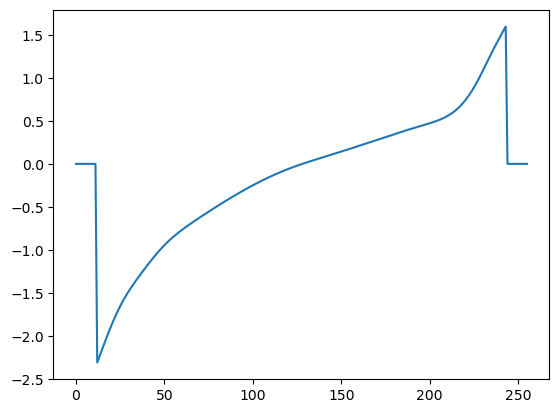

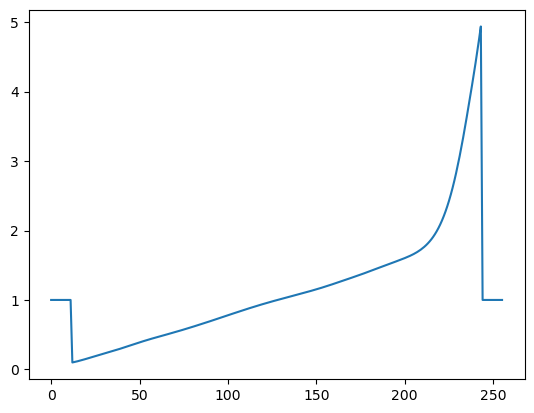

In [16]:
## Plot g
method = 'tent'
lamb = 100

g, lE = gsolve(selected_pixels, np.log(exposure_times), lamb, w_functions[method])
print(g.shape, lE.shape)

plt.plot(range(256), g)
plt.show()
plt.plot(range(256), np.exp(g))
plt.show()

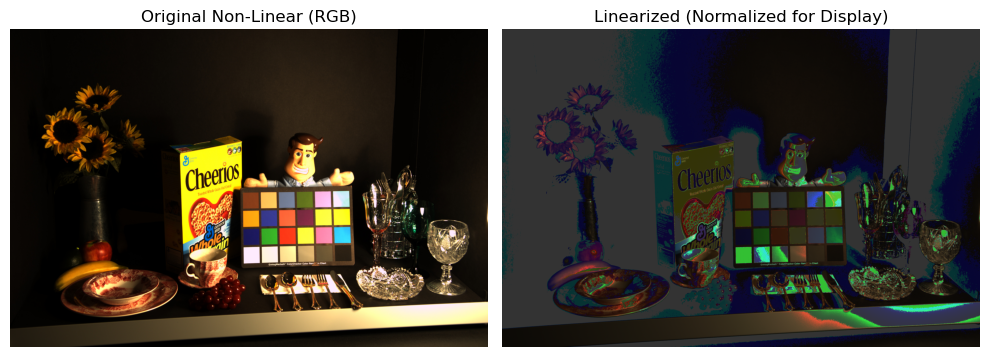

In [17]:
img_test = imread(os.path.join("data", "Lab Booth", 
                                  "_MDF0024.jpg"))



img_lin = convert_to_linear_image_rgb(img_test, g, norm=True)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original Non-Linear (RGB)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_lin)
plt.title("Linearized (Normalized for Display)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
from imageio.v2 import imread
jpg_files = []
tiff_files = []
for i in range(19, 27):
    jpg_files.append(os.path.join("data", "Lab Booth" 
                                   , f"_MDF00{i}.jpg"))
    tiff_files.append(os.path.join("data", "Lab Booth" 
                                   , f"_MDF00{i}.jpg"))
print(jpg_files)
print(tiff_files)

tiff_images = np.array([imread(f).astype(np.float32) / (2**16  -1)  for f in tiff_files])
print(tiff_images.shape)


jpg_images_ldr = np.array([imread(f).astype(np.float32)/ (2**8  -1) for f in jpg_files])
print(jpg_images_ldr.shape)
print(jpg_images_ldr.max(), jpg_images_ldr.min())
jpg_images_lin = np.array([convert_to_linear_image_rgb(imread(f), g).astype(np.float32) for f in jpg_files])
print(jpg_images_lin.shape)


hdr_result_tiff = merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
hdr_result_jpg = merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)



log_hdr_result_tiff = log_merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
log_hdr_result_jpg = log_merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)


def writeHDR(name, data):

    cv2.imwrite(name, data[:, :, ::-1].astype(np.float32))

writeHDR("tiff_hdr.hdr", hdr_result_tiff)
writeHDR("jpg_hdr.hdr", hdr_result_jpg)

writeHDR("tiff_log_hdr.hdr", log_hdr_result_tiff)
writeHDR("jpg_log_hdr.hdr", log_hdr_result_jpg)


['data\\Lab Booth\\_MDF0019.jpg', 'data\\Lab Booth\\_MDF0020.jpg', 'data\\Lab Booth\\_MDF0021.jpg', 'data\\Lab Booth\\_MDF0022.jpg', 'data\\Lab Booth\\_MDF0023.jpg', 'data\\Lab Booth\\_MDF0024.jpg', 'data\\Lab Booth\\_MDF0025.jpg', 'data\\Lab Booth\\_MDF0026.jpg']
['data\\Lab Booth\\_MDF0019.jpg', 'data\\Lab Booth\\_MDF0020.jpg', 'data\\Lab Booth\\_MDF0021.jpg', 'data\\Lab Booth\\_MDF0022.jpg', 'data\\Lab Booth\\_MDF0023.jpg', 'data\\Lab Booth\\_MDF0024.jpg', 'data\\Lab Booth\\_MDF0025.jpg', 'data\\Lab Booth\\_MDF0026.jpg']
(8, 2868, 4312, 3)
(8, 2868, 4312, 3)
1.0 0.0
(8, 2868, 4312, 3)


#### *Choose one of the HDR images you have created, commenting on the reason for your choice.*

Among the HDR images, I chose the one created using the logarithmic merging scheme and the tent weighting function on linearized JPG images. I selected this image because it had the most balanced and natural look. Compared to the others, which were either too high or too low in contrast, this one provided a good balance between dark and bright areas. However, I didn’t notice a significant difference in quality. In fact, the JPG images looked better, possibly because they had more appropriate exposure settings. On the other hand, the TIFF-based HDRs appeared overexposed.

*Store the resulting HDR images as \texttt{.HDR} files, which is an open source high dynamic range file format. (See the provided function **`writeHDR`**  ./src/cp\_assgn2.py)*

In [ ]:
import matplotlib.pyplot as plt
from imageio.v2 import imread
import os
import cv2 

try:
    from src.cp_assgn2 import read_colorchecker_gm
except ImportError:
    print("Warning: Could not import read_colorchecker_gm")
    def read_colorchecker_gm():
        print("Using placeholder read_colorchecker_gm")
        return np.random.rand(4, 6), np.random.rand(4, 6), np.random.rand(4, 6)

def writeHDR(name, data):
    data_float32 = data.astype(np.float32)
    cv2.imwrite(name, data_float32[:, :, ::-1])
    print(f"Saved HDR image to: {name}")

## 2. Color correction and white balancing (20 points)

For this part, you are expected to use the **read_colorchecker_gm()** function provided in **./src/cp_assgn2.py**., which **returns a 4x6 matrix with sRGB linear values of the Greatg-Macbeth color checker.** 



1. For each color checker patch, crop a square that is fully contained within the patch. (See mat-plotlib function matplotlib.pyplot.ginput for interactively recording image coordinates). Make sure to store the coordinates of these cropped squares, so that you can re-use them. Use the resulting 24 crops to compute average RGB coordinates for each of the color checker’s 24 patches
2. Convert these computed RGB coordinates into homogeneous 4 × 1 coordinates, by appending a 1 as their fourth coordinate.
3. Solve a least-squares problem to compute an affine transformation, mapping the measured to the ground-truth  homogeneous coordinates.
4. Apply the computed affine transform to your original RGB HDR image. Note that the
transformed image may have some negative values, which you should clip to 0.
5. Finally, apply an additional white balancing transform (i.e., multiply each channel with a scalar), so that the RGB coordinates of patch 4 are equal to each other. This is analogous to the manual white balancing in Programming Assignment 1, where now we use patch 4 as the white object in the scene.

Store the color corrected and white balanced HDR image in an .HDR file. You should now have two HDR images total: The one from Part 1 that has not been color-corrected, and the one you just created. Compare the color-corrected image with the original, and discuss which one you like the best.


In [73]:
# for each color patch: get 24 crops
def get_patch_coordinates(image_for_coords, patch_coord_file='patch_coords.npy'):
   
    if os.path.exists(patch_coord_file):
        print(f"Loading patch coordinates from {patch_coord_file}")
        return np.load(patch_coord_file).tolist()

    plt.imshow(np.clip(image_for_coords**(1/2.2), 0, 1)) # Display gamma corrected for better visibility
    
    # ginput returns list of (x, y) tuples
    coords_xy = plt.ginput(24, timeout=-1)
    plt.close()

    if len(coords_xy) != 24:
        raise ValueError

    # Convert (x, y) to (row, col) i.e., (y, x) and ensure they are integers
    coords_yx = [(int(round(y)), int(round(x))) for x, y in coords_xy]

    np.save(patch_coord_file, np.array(coords_yx))
    return coords_yx


In [74]:
# compute average RGB coordinates for each of the color checker’s 24 patches and convert them to 4x1 coords by adding a 1import numpy as np
def extract_patch_averages(image, patch_centers, crop_size=10):
   
    num_patches = len(patch_centers)
    if num_patches == 0:
        return np.empty((0, 3), dtype=np.float64) # Handle empty list case

    avg_rgbs = np.zeros((num_patches, 3), dtype=np.float64) # Size based on input list length
   

    h, w, _ = image.shape
    half_crop = crop_size // 2

    for i, (center_y, center_x) in enumerate(patch_centers):
        # Define crop boundaries, ensuring they are within image bounds
        y1 = max(0, center_y - half_crop)
        y2 = min(h, center_y + half_crop + (crop_size % 2)) # +1 if odd size
        x1 = max(0, center_x - half_crop)
        x2 = min(w, center_x + half_crop + (crop_size % 2))

        if y1 >= y2 or x1 >= x2:
             avg_rgbs[i, :] = np.nan 
             continue

        patch = image[y1:y2, x1:x2, :]
        # Calculate average
        if patch.size > 0:
             avg_rgbs[i, :] = np.mean(patch, axis=(0, 1))
        else:
             print(f"Warning: Patch center index {i} crop is empty. Setting average to NaN.")
             avg_rgbs[i, :] = np.nan

    # Check for NaNs at the end if needed
    if np.isnan(avg_rgbs).any():
         print("Warning")

    return avg_rgbs

In [75]:
# compute an affine transformation
def calculate_affine_correction_matrix(measured_rgb, reference_rgb_flat):
    
    if measured_rgb.shape != (24, 3) or reference_rgb_flat.shape != (24, 3):
        raise ValueError("Input RGB arrays must have shape (24, 3)")

    measured_hom = np.hstack([measured_rgb, np.ones((24, 1))])
    reference_hom = np.hstack([reference_rgb_flat, np.ones((24, 1))])


    M_transpose = np.linalg.lstsq(measured_hom, reference_hom, rcond=None)[0]
    M_affine = M_transpose.T # We want M

    # The resulting M_affine is 4x4
    print(M_affine)
    return M_affine

In [76]:
# Apply the computed affine transform to your original RGB HDR image
def apply_affine_color_correction(hdr_image, M_affine):
    
    h, w, c = hdr_image.shape
    if c != 3:
        raise ValueError
    if M_affine.shape != (4, 4):
         raise ValueError

    hdr_flat = hdr_image.reshape(-1, 3)
    hdr_hom = np.hstack([hdr_flat, np.ones((h * w, 1))]) # Shape (N, 4)

    M_transpose = M_affine.T
    corrected_hom_flat = hdr_hom @ M_transpose # Shape (N, 4)

    corrected_flat = corrected_hom_flat[:, :3]

    # Reshape back to image dimensions
    corrected_image = corrected_flat.reshape(h, w, 3)

    corrected_image_clipped = np.clip(corrected_image, 0, None)
    

    return corrected_image_clipped


In [77]:
# Apply white balancing
def apply_patch4_white_balance(corrected_hdr_image, patch_centers, patch_index=3, crop_size=10):
   
    if not (0 <= patch_index < 24):
         raise ValueError("btween 0 and 23.")

    patch4_center = patch_centers[patch_index]
    avg_rgb_patch4 = extract_patch_averages(corrected_hdr_image, [patch4_center], crop_size=crop_size)[0]

    if np.isnan(avg_rgb_patch4).any() or np.any(avg_rgb_patch4 <= 0):
        
        return corrected_hdr_image.copy() # Return unchanged image

    r4, g4, b4 = avg_rgb_patch4
   

    avg_intensity = (r4 + g4 + b4) / 3.0

    gain_r = avg_intensity / r4 if r4 > 1e-6 else 1.0
    gain_g = avg_intensity / g4 if g4 > 1e-6 else 1.0
    gain_b = avg_intensity / b4 if b4 > 1e-6 else 1.0

    

    balanced_image = corrected_hdr_image.copy()
    balanced_image[:, :, 0] *= gain_r
    balanced_image[:, :, 1] *= gain_g
    balanced_image[:, :, 2] *= gain_b

    balanced_image_clipped = np.clip(balanced_image, 0, None)
    

   

    return balanced_image_clipped

In [80]:
# Store the color corrected HDR image
import matplotlib
try:
    matplotlib.use('Agg')     
except ImportError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from imageio.v2 import imread
import os
import cv2

hdr_image_path = "jpg_hdr.hdr"
output_hdr_path = "corrected_wb.hdr"
source_image_for_coords_path = os.path.join("data", "Lab Booth", "_MDF0023.tiff")
patch_crop_size = 10

manual_patch_centers = [
    (1460, 3368), (1320, 3368), (1160, 3360), (1000, 3360), (830, 3340), (670, 3340), # Row 1 (Patches 1-6)
    (1460, 3510), (1320, 3510), (1160, 3510), (1000, 3510), (830, 3510), (670, 3510), # Row 2 (Patches 7-12)
    (1460, 3655), (1320, 3655), (1160, 3655), (1000, 3655), (830, 3655), (670, 3655), # Row 3 (Patches 13-18)
    (1460, 3810), (1320, 3810), (1160, 3810), (1000, 3810), (830, 3810), (670, 3810)  # Row 4 (Patches 19-24)
]
if len(manual_patch_centers) != 24:
    raise ValueError

patch_centers = manual_patch_centers 


hdr_image_bgr = cv2.imread(hdr_image_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
if hdr_image_bgr is None:
    raise FileNotFoundError(f"Could not load HDR image: {hdr_image_path}")
hdr_image_rgb = hdr_image_bgr[:, :, ::-1].astype(np.float64)

print(f"Loading source image for coordinates from: {source_image_for_coords_path}")
source_image = imread(source_image_for_coords_path).astype(np.float64) / (2**16 - 1)



r_ref, g_ref, b_ref = read_colorchecker_gm()
reference_rgb_flat = np.stack([r_ref.flatten(), g_ref.flatten(), b_ref.flatten()], axis=1)

measured_rgb = extract_patch_averages(source_image, patch_centers, crop_size=patch_crop_size)

M_affine = calculate_affine_correction_matrix(measured_rgb, reference_rgb_flat)


corrected_hdr_image = apply_affine_color_correction(hdr_image_rgb, M_affine)

final_hdr_image = apply_patch4_white_balance(corrected_hdr_image, patch_centers, patch_index=3, crop_size=patch_crop_size)


writeHDR(output_hdr_path, final_hdr_image)

try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.clip(hdr_image_rgb**(1/2.2), 0, 1))
    axes[0].set_title("Original HDR (Gamma Corrected)")
    axes[0].axis('off')

    axes[1].imshow(np.clip(final_hdr_image**(1/2.2), 0, 1))
    axes[1].set_title("Corrected & WB HDR (Gamma Corrected)")
    axes[1].axis('off')

    plt.tight_layout()
    comparison_output_path = "hdr_comparison.png"
    plt.savefig(comparison_output_path)
    plt.close(fig) 
    plt.show() 

except Exception as e:
    print(f"Could not generate comparison plot: {e}")
print("\n--- Process Complete ---")


Loading source image for coordinates from: data\Lab Booth\_MDF0023.tiff
[[-9.92419949e+00 -2.04951874e+01  4.45295536e+01  4.89052746e-01]
 [ 4.47893181e-01 -1.55611135e+00  4.87130609e-01  2.77259196e-01]
 [ 1.64718515e+00  8.22223812e+00 -1.47824313e+01  1.47006090e-01]
 [ 2.63694430e-14 -9.31715917e-15 -2.77619139e-14  1.00000000e+00]]

--- Process Complete ---


C:\Users\emre can\AppData\Local\Temp\ipykernel_9452\3166935283.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


##### *Compare the color-corrected and the original image here, discussing which one you like better.*

In [ ]:
Original image

### 3. Photographic tonemapping (20 points)

You need to tonemap the HDR image you like better at the end of the last part for displaying purposes.
You will implement the tonemapping operator proposed by Reinhard et al. [2].
For implementation details, refer to the homework text and the paper.

*You may get better results by using the same scalars for all three channels. You can do this by using pixels from all three channels in the equations.*

$I_{white} = B. max_{i,j}(I_{ij,HDR})$,

$I_{i,j,HDR} = \frac{K}{I_{m,HDR}}$

$I_{m,HDR} = exp(1/N∑_{i,j}log(I_{ij,HDR} + ϵ))$ **Equation (10)**

The parameter K is the key, and determines how bright or dark the resulting tonemapped rendition is. The parameter B is the burn, and can be used to  suppress the contrast of the result. Finally, N is the number of pixels, and ε is a small constant to avoid the singularity of the logarithm function at 0. 

**Even with tonemapping, your images may appear too dark. After tonemapping, you need to apply gamma encoding for images to be displayed correctly.**


In [65]:
try:
    from src.cp_assgn2 import lRGB2XYZ, XYZ2lRGB , xyY_to_XYZ
    print("Successfully")
except ImportError:
    print("Error")
def writeLDR(name, data, gamma=2.2):
    """Writes an LDR image, applying gamma correction and scaling to 0-255."""
    # Apply gamma correction
    ldr_gamma_corrected = np.clip(data**(1.0/gamma), 0.0, 1.0)
    # Scale to 0-255 and convert to uint8
    ldr_uint8 = (ldr_gamma_corrected * 255.0).astype(np.uint8)
    # OpenCV expects BGR for imwrite
    cv2.imwrite(name, ldr_uint8[:, :, ::-1])
    print(f"Saved LDR image to: {name}")

# --- XYZ <-> xyY Conversion ---
def xyY_to_XYZ(xyY):
    """Converts xyY (luminance + chromaticity) back to XYZ color space."""
    x, y, Y = xyY[..., 0], xyY[..., 1], xyY[..., 2]

    # Avoid division by zero when y is zero
    X = np.divide(x * Y, y, out=np.zeros_like(Y), where=y!=0)
    Z = np.divide((1 - x - y) * Y, y, out=np.zeros_like(Y), where=y!=0)

    # Handle cases where Y is zero explicitly if needed (X=0, Y=0, Z=0)
    # The division logic should handle Y=0 correctly, resulting in X=0, Z=0.

    # Stack results: X, Y, Z
    XYZ = np.stack((X, Y, Z), axis=-1)
    return XYZ
def XYZ_to_xyY(XYZ):
    
    X, Y, Z = XYZ[..., 0], XYZ[..., 1], XYZ[..., 2]

    # Calculate sum, avoid division by zero
    denom = X + Y + Z
    # Where denom is zero, prevent division and set x, y to a default (e.g., 0)
    # Or use reference white chromaticity if available (e.g., D65 approx x=0.3127, y=0.3290)
    x = np.divide(X, denom, out=np.zeros_like(X), where=denom!=0)
    y = np.divide(Y, denom, out=np.zeros_like(Y), where=denom!=0)

    # Handle cases where Y is zero (should result in x=0, y=0?)
    # The division already handles X=0, Y=0, Z=0 case.

    # Stack results: x, y, Y
    xyY = np.stack((x, y, Y), axis=-1)
    return xyY
def reinhard_tonemap_channel(channel_hdr, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard photographic tone mapping to a single channel HDR image.

    Args:
        channel_hdr (np.ndarray): Single channel (grayscale) HDR image data.
        K (float): Key value (controls brightness).
        B (float): Burn value (controls white point / contrast).
        epsilon (float): Small value to avoid log(0).

    Returns:
        np.ndarray: Tone-mapped single channel LDR image (values typically 0-1).
    """
    if channel_hdr.ndim != 2:
        raise ValueError("Input must be a single channel (2D array).")
    if np.any(channel_hdr < 0):
         print("Warning: Input channel contains negative values. Clipping to 0.")
         channel_hdr = np.maximum(channel_hdr, 0)

    N = channel_hdr.size # Total number of pixels

    # Equation (11): Calculate log-average luminance Im,HDR
    log_luminance = np.log(channel_hdr + epsilon)
    sum_log_lum = np.sum(log_luminance)
    I_m_hdr = np.exp(sum_log_lum / N)
    print(f"  Log-average (Im,HDR): {I_m_hdr:.4f}")

    # Equation (10): Calculate scaled luminance Îij,HDR
    I_scaled_hdr = (K / I_m_hdr) * channel_hdr
    print(f"  Max scaled luminance (max Îij,HDR): {np.max(I_scaled_hdr):.4f}")


    # Equation (9): Calculate white point Îwhite
    # Note: The formula uses max(Îij,HDR), which is the max of the scaled luminance
    I_white = B * np.max(I_scaled_hdr)
    print(f"  White point (Îwhite): {I_white:.4f}")


    # Equation (8): Apply main tone mapping formula
    numerator = I_scaled_hdr * (1 + (I_scaled_hdr / (I_white**2)))
    denominator = 1 + I_scaled_hdr

    # Avoid division by zero if denominator is somehow zero (unlikely)
    I_tm = np.divide(numerator, denominator, out=np.zeros_like(channel_hdr), where=denominator!=0)

    # Result should ideally be in [0, 1], but clip just in case
    I_tm_clipped = np.clip(I_tm, 0.0, 1.0)

    return I_tm_clipped
def reinhard_tonemap_rgb(hdr_image_rgb, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard tone mapping simultaneously to R, G, B channels.
    """
    if hdr_image_rgb.ndim != 3 or hdr_image_rgb.shape[2] != 3:
        raise ValueError("Input must be a 3-channel RGB image.")

    print("Applying Reinhard Tone Mapping (RGB Simultaneous)...")
    ldr_image_rgb = np.zeros_like(hdr_image_rgb)

    for i in range(3): # Iterate through R, G, B channels
        channel_name = ['R', 'G', 'B'][i]
        print(f"Processing channel: {channel_name}")
        ldr_image_rgb[..., i] = reinhard_tonemap_channel(hdr_image_rgb[..., i], K, B, epsilon)

    print("RGB Simultaneous Tone Mapping Complete.")
    return ldr_image_rgb
def reinhard_tonemap_luminance(hdr_image_rgb, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard tone mapping to the luminance (Y) channel only.
    Requires lRGB2XYZ, XYZ2xyY, xyY2XYZ, XYZ2lRGB.
    """
    if hdr_image_rgb.ndim != 3 or hdr_image_rgb.shape[2] != 3:
        raise ValueError("Input must be a 3-channel RGB image.")

    print("Applying Reinhard Tone Mapping (Luminance Channel)...")

    # 1. Convert RGB to XYZ
    print("Converting RGB -> XYZ...")
    hdr_xyz = lRGB2XYZ(hdr_image_rgb)

    # 2. Convert XYZ to xyY
    print("Converting XYZ -> xyY...")
    hdr_xyY = XYZ_to_xyY(hdr_xyz)

    # Extract Luminance (Y channel)
    Y_hdr = hdr_xyY[..., 2]

    # 3. Tone map only the Y channel
    print("Processing channel: Y (Luminance)")
    Y_tm = reinhard_tonemap_channel(Y_hdr, K, B, epsilon)

    # Keep original chromaticity (x, y)
    x_chroma = hdr_xyY[..., 0]
    y_chroma = hdr_xyY[..., 1]

    # 4. Combine tone-mapped Y with original x, y
    tm_xyY = np.stack((x_chroma, y_chroma, Y_tm), axis=-1)

    # 5. Convert back to XYZ
    print("Converting xyY -> XYZ...")
    tm_xyz = xyY_to_XYZ(tm_xyY)

    # 6. Convert back to RGB
    print("Converting XYZ -> RGB...")
    tm_rgb = XYZ2lRGB(tm_xyz)

    # Clip final result to [0, 1] as conversions might slightly exceed bounds
    tm_rgb_clipped = np.clip(tm_rgb, 0.0, 1.0)

    print("Luminance Channel Tone Mapping Complete.")
    return tm_rgb_clipped

Successfully imported lRGB2XYZ and XYZ2lRGB.


In [81]:
corrected_hdr_path = "corrected_wb.hdr" 
print(f"Loading corrected HDR image from: {corrected_hdr_path}")
hdr_corrected_bgr = cv2.imread(corrected_hdr_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
if hdr_corrected_bgr is None:
    raise FileNotFoundError(f"Could not load corrected HDR image: {corrected_hdr_path}")
hdr_corrected_rgb = hdr_corrected_bgr[:, :, ::-1].astype(np.float64) # Use float64

# Tone Mapping Parameters (Experiment with these!)
key_value = 0.0005 # K
burn_value = 0.999 # B
epsilon_value = 1e-8

# --- Apply Method 1: RGB Simultaneous ---
ldr_rgb_simultaneous = reinhard_tonemap_rgb(hdr_corrected_rgb, K=key_value, B=burn_value, epsilon=epsilon_value)
writeLDR(f"tm_rgb_K{key_value}_B{burn_value}.png", ldr_rgb_simultaneous)

# --- Apply Method 2: Luminance Only ---
# Check if conversion functions are available before trying
if 'lRGB2XYZ' in globals() and 'XYZ2lRGB' in globals():
     try:
        ldr_luminance_only = reinhard_tonemap_luminance(hdr_corrected_rgb, K=key_value, B=burn_value, epsilon=epsilon_value)
        writeLDR(f"tm_lum_K{key_value}_B{burn_value}.png", ldr_luminance_only)
     except NameError as e:
         print(f"Skipping Luminance method due to missing function: {e}")
     except Exception as e:
         print(f"An error occurred during Luminance method: {e}")

    


# --- Display Results (Optional) ---
try:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ldr_rgb_simultaneous) # LDR images are already 0-1, no gamma needed for direct display here if saved correctly
    plt.title(f"Tone Mapped (RGB Sim) K={key_value}, B={burn_value}")
    plt.axis('off')

    if 'ldr_luminance_only' in locals(): # Check if luminance method ran
        plt.subplot(1, 2, 2)
        plt.imshow(ldr_luminance_only)
        plt.title(f"Tone Mapped (Lum Only) K={key_value}, B={burn_value}")
        plt.axis('off')
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Luminance method skipped', horizontalalignment='center', verticalalignment='center')
        plt.axis('off')


    plt.tight_layout()
    comparison_tm_path = f"tm_comparison_K{key_value}_B{burn_value}.png"
    plt.savefig(comparison_tm_path)
    
    plt.show() 

except Exception as e:
    print(f"Could not generate tone mapping comparison plot: {e}")



Loading corrected HDR image from: corrected_wb.hdr
Applying Reinhard Tone Mapping (RGB Simultaneous)...
Processing channel: R
  Log-average (Im,HDR): 0.0000
  Max scaled luminance (max Îij,HDR): 1310448836.7923
  White point (Îwhite): 1309138387.9555
Processing channel: G
  Log-average (Im,HDR): 0.0000
  Max scaled luminance (max Îij,HDR): 15158397.3632
  White point (Îwhite): 15143238.9658
Processing channel: B
  Log-average (Im,HDR): 2.8879
  Max scaled luminance (max Îij,HDR): 2.7037
  White point (Îwhite): 2.7010
RGB Simultaneous Tone Mapping Complete.
Saved LDR image to: tm_rgb_K0.0005_B0.999.png
Applying Reinhard Tone Mapping (Luminance Channel)...
Converting RGB -> XYZ...
Converting XYZ -> xyY...
Processing channel: Y (Luminance)
  Log-average (Im,HDR): 1.0746
  Max scaled luminance (max Îij,HDR): 39.1070
  White point (Îwhite): 39.0679
Converting xyY -> XYZ...
Converting XYZ -> RGB...
Luminance Channel Tone Mapping Complete.
Saved LDR image to: tm_lum_K0.0005_B0.999.png


C:\Users\emre can\AppData\Local\Temp\ipykernel_9452\4079523532.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### 4. (Bonus)  Create and tonemap your own HDR photos (50 points)

* Apply your implementation on a photograph you have taken. For this, you need to choose a scene with high dynamic range. See the hints section in the homework text for the camera settings.
* Once you select the scene, capture exposure stacks in RAW and JPEG formats. We suggest using exposures that are equally spaced in the logarithmic domain. For example, start with some very low base exposure, and then use exposures that are 2× the base, 4×, 8×, and so on.
* Use the exposure stacks you captured to create two HDR images, one from the RAW and one from the JPEG images. Store these images in .HDR format. You do not need color calibration. 
*Then, process these images using the tonemapping algorithms you implemented in Part 3 (photographic, in RGB or luminance-only). Experiment with different parameters, show a few representative tonemaps, discuss your results, and determine which result you like the most.

In [ ]:
## Load your images 

In [ ]:
## Create two HDR images (one from RAW and one from JPEG imgs) using the above implemented algorithms

In [ ]:
## Tonemap the images with the above-implemented algorithms (in Part 3). Experiment with different parameters. Show some tonemaps

##### *Discuss the above-generated images, commenting on which one you like the best.*

### **REFERENCES**
[1] P. E. Debevec and J. Malik. Recovering high dynamic range radiance maps from photographs.
In Proceedings of the 24th Annual Conference on Computer Graphics and Interactive Techniques,
SIGGRAPH ’97, pages 369–378, New York, NY, USA, 1997. ACM Press/Addison-Wesley Publishing
Co.

[2] E. Reinhard, M. Stark, P. Shirley, and J. Ferwerda. Photographic tone reproduction for digital
images. In Proceedings of the 29th Annual Conference on Computer Graphics and Interactive
Techniques, SIGGRAPH ’02, pages 267–276, New York, NY, USA, 2002. ACM.
